# Interpreting Bi-LSTM Sentiment Classification Models With Integrated Gradients

Interpretations of the predictions are generated and visualized using Integrated Gradients algorithm, specifically the `IntGradNLPInterpreter` class.

In [2]:
import paddle
import numpy as np
import interpretdl as it

from interpretdl.data_processor.visualizer import VisualizationTextRecord, visualize_text

If you have't done so, please first download the word dictionary that maps each word to an id.

## Bi-LSTM

### 加载数据集
以公开中文情感分析数据集ChnSenticorp为例。PaddleNLP已经内置该数据集，一键即可加载。

In [3]:
import paddlenlp as ppnlp
from paddlenlp.datasets import load_dataset

train_ds, dev_ds, test_ds = load_dataset(
    "chnsenticorp", splits=["train", "dev", "test"])

print(train_ds.label_list)

for data in train_ds[:5]:
    print(data)

['0', '1']
{'text': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1, 'qid': ''}
{'text': '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错', 'label': 1, 'qid': ''}
{'text': '房间太小。其他的都一般。。。。。。。。。', 'label': 0, 'qid': ''}
{'text': '1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸，一摸一个印. 4.硬盘分区不好办.', 'label': 0, 'qid': ''}
{'text': '今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量商量,单独出个第6卷,让我们的孩子不会有所遗憾。', 'label': 1, 'qid': ''}


每条数据包含一句评论和对应的标签，0或1。0代表负向评论，1代表正向评论。

之后，还需要对输入句子进行数据处理，如切词，映射词表id等。

### 构建词汇表

In [4]:
# downloads the word dict to assets/
# 在模型训练之前，需要先下载词汇表文件word_dict.txt，用于构造词-id映射关系。

# !wget https://paddlenlp.bj.bcebos.com/data/senta_word_dict.txt -P assets/

In [5]:
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab

VOCAB_PATH = "assets/senta_word_dict.txt"

vocab = Vocab.load_vocabulary(VOCAB_PATH, unk_token='[UNK]', pad_token='[PAD]')

vocab_size = len(vocab)
num_classes = len(train_ds.label_list)
pad_token_id = vocab.to_indices('[PAD]')

### 模型搭建

In [6]:
import paddle.nn as nn
import paddle.nn.functional as F
import paddlenlp

class LSTMModel(nn.Layer):
    def __init__(self,
                 vocab_size,
                 num_classes,
                 emb_dim=128,
                 padding_idx=0,
                 lstm_hidden_size=198,
                 direction='forward',
                 lstm_layers=1,
                 dropout_rate=0.0,
                 pooling_type=None,
                 fc_hidden_size=96):
        super().__init__()

        # 首先将输入word id 查表后映射成 word embedding
        self.embedder = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_dim,
            padding_idx=padding_idx)

        # 将word embedding经过LSTMEncoder变换到文本语义表征空间中
        self.lstm_encoder = paddlenlp.seq2vec.LSTMEncoder(
            emb_dim,
            lstm_hidden_size,
            num_layers=lstm_layers,
            direction=direction,
            dropout=dropout_rate,
            pooling_type=pooling_type)

        # LSTMEncoder.get_output_dim()方法可以获取经过encoder之后的文本表示hidden_size
        self.fc = nn.Linear(self.lstm_encoder.get_output_dim(), fc_hidden_size)

        # 最后的分类器
        self.output_layer = nn.Linear(fc_hidden_size, num_classes)

    def forward(self, text, seq_len):
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(text)

        # Shape: (batch_size, num_tokens, num_directions*lstm_hidden_size)
        # num_directions = 2 if direction is 'bidirectional' else 1
        text_repr = self.lstm_encoder(embedded_text, sequence_length=seq_len)


        # Shape: (batch_size, fc_hidden_size)
        fc_out = paddle.tanh(self.fc(text_repr))

        # Shape: (batch_size, num_classes)
        logits = self.output_layer(fc_out)
        return logits

model_ = LSTMModel(
        len(vocab),
        len(train_ds.label_list),
        direction='bidirectional',
        padding_idx=vocab['[PAD]'])

model = paddle.Model(model_)

### 组网训练

In [7]:
from functools import partial

def convert_example(example, tokenizer, is_test=False):

    input_ids = tokenizer.encode(example["text"])
    valid_length = np.array(len(input_ids), dtype='int64')
    input_ids = np.array(input_ids, dtype='int64')

    if not is_test:
        label = np.array(example["label"], dtype="int64")
        return input_ids, valid_length, label
    else:
        qid = np.array(example["qid"], dtype="int64")
        return input_ids, valid_length, qid
    

def create_dataloader(dataset,
                      trans_fn=None,
                      mode='train',
                      batch_size=1,
                      use_gpu=False,
                      batchify_fn=None):
    """
    Creats dataloader.

    Args:
        dataset(obj:`paddle.io.Dataset`): Dataset instance.
        trans_fn(obj:`callable`, optional, defaults to `None`): function to convert a data sample to input ids, etc.
        mode(obj:`str`, optional, defaults to obj:`train`): If mode is 'train', it will shuffle the dataset randomly.
        batch_size(obj:`int`, optional, defaults to 1): The sample number of a mini-batch.
        use_gpu(obj:`bool`, optional, defaults to obj:`False`): Whether to use gpu to run.
        batchify_fn(obj:`callable`, optional, defaults to `None`): function to generate mini-batch data by merging
            the sample list, None for only stack each fields of sample in axis
            0(same as :attr::`np.stack(..., axis=0)`).

    Returns:
        dataloader(obj:`paddle.io.DataLoader`): The dataloader which generates batches.
    """
    if trans_fn:
        dataset = dataset.map(trans_fn)

    if mode == 'train' and use_gpu:
        sampler = paddle.io.DistributedBatchSampler(
            dataset=dataset, batch_size=batch_size, shuffle=True)
    else:
        shuffle = True if mode == 'train' else False
        sampler = paddle.io.BatchSampler(
            dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    dataloader = paddle.io.DataLoader(
        dataset,
        batch_sampler=sampler,
        return_list=True,
        collate_fn=batchify_fn)
    return dataloader

# Reads data and generates mini-batches.
tokenizer = JiebaTokenizer(vocab)
trans_fn = partial(convert_example, tokenizer=tokenizer, is_test=False)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=vocab.token_to_idx.get('[PAD]', 0)),  # input_ids
    Stack(dtype="int64"),  # seq len
    Stack(dtype="int64")  # label
): [data for data in fn(samples)]
                        
train_loader = create_dataloader(
    train_ds,
    trans_fn=trans_fn,
    batch_size=128,
    mode='train',
    batchify_fn=batchify_fn)
                        
dev_loader = create_dataloader(
    dev_ds,
    trans_fn=trans_fn,
    batch_size=128,
    mode='validation',
    batchify_fn=batchify_fn)

optimizer = paddle.optimizer.Adam(
    parameters=model.parameters(), learning_rate=5e-4)

# Defines loss and metric.
criterion = paddle.nn.CrossEntropyLoss()
metric = paddle.metric.Accuracy()

model.prepare(optimizer, criterion, metric)

In [8]:
# model.fit(
#     train_loader,
#     dev_loader,
#     epochs=2,
#     save_dir='assets/checkpoint',
#     verbose=1
# )

### 模型预测
训练保存好的训练，即可用于预测。如以下示例代码自定义预测数据，调`用`predict()`函数即可一键预测。

In [9]:
# 模型加载
state_dict = paddle.load("assets/checkpoint/final.pdparams")
model_.set_dict(state_dict)

## Interpreting transformer ERNIE TextClassification Models

Initialize the `IntGradNLPInterpreter`. 

In [10]:
ig = it.GradShapNLPInterpreter(model_, True)

Define the reviews that we want to analyze. 

In [11]:
reviews = [
    '这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般',
    '作为老的四星酒店，房间依然很整洁，相当不错。机场接机服务很好，可以在车上办理入住手续，节省时间。'
]

In [12]:
import jieba

def preprocess_fn(data):
    texts = []
    seq_lens = []
    for text in data:
        tokens = " ".join(jieba.cut(text)).split(' ')
#         tokens = text.split()
        ids = []
        unk_id = vocab.token_to_idx.get('[UNK]', None)
        for token in tokens:
            wid = vocab.token_to_idx.get(token, unk_id)
            if wid:
                ids.append(wid)
        texts.append(ids)
        seq_lens.append(len(ids))

    pad_token_id = 0
    max_seq_len = max(seq_lens)
    for index, text in enumerate(texts):
        seq_len = len(text)
        if seq_len < max_seq_len:
            padded_tokens = [pad_token_id for _ in range(max_seq_len - seq_len)]
            new_text = text + padded_tokens
            texts[index] = new_text
        elif seq_len > max_seq_len:
            new_text = text[:max_seq_len]
            texts[index] = new_text
    texts = paddle.to_tensor(texts)
    texts.stop_gradient = False
    seq_lens = paddle.to_tensor(seq_lens)
    seq_lens.stop_gradient = False
    return texts, seq_lens

Define a preprocessing function that processes a list of raw strings into model inputs.

In the cell below, we `interpret` reviews and grab weights for each token.

Since the output gradients are not grouped by reviews due to the LoDTensor inputs, we use the LoD information to group them into a list of lists.

In [13]:
pred_labels, pred_probs, avg_gradients = ig.interpret(
    preprocess_fn(reviews),
    return_pred=True,
    visual=True)

sum_gradients = np.sum(avg_gradients, axis=-1).tolist()

new_array = []
for i in range(len(reviews)):
    new_array.append(
        list(zip(" ".join(jieba.cut(reviews[i])).split(' '), sum_gradients[i])))

Building prefix dict from the default dictionary ...
Loading model from cache /root/tmp/jieba.cache
Loading model cost 0.588 seconds.
Prefix dict has been built successfully.
/opt/conda/envs/paddle2/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/paddle2/lib/python3.7/site-packages/paddle/fluid/dygraph/varbase_patch_methods.py:379: UserWarning: 
tensor.grad will return the tensor value of the gradient. 
  warnings.warn(warning_msg)


For visualizasion purposes, word weights in each review are normalized to better illustrate differences between weights. Results for each review is stored in a list by making use of the `VisualizationTextRecord`.

In [14]:
pred_labels, pred_probs, avg_gradients = ig.interpret(
    preprocess_fn(reviews),
    return_pred=True,
    visual=True)

sum_gradients = np.sum(avg_gradients, axis=-1).tolist()

new_array = []
for i in range(len(reviews)):
    new_array.append(
        list(zip(" ".join(jieba.cut(reviews[i])).split(' '), sum_gradients[i])))


In [15]:
true_labels = [0, 1]
recs = []
for i, l in enumerate(new_array):
    words = [t[0] for t in l]
    word_importances = [t[1] for t in l]
    word_importances = np.array(word_importances) / np.linalg.norm(
        word_importances)
    pred_label = pred_labels[i]
    pred_prob = pred_probs[i]
    true_label = true_labels[i]
    interp_class = pred_label
    if interp_class == 0:
        word_importances = -word_importances
    recs.append(
        VisualizationTextRecord(words, word_importances, true_label,
                                pred_label, pred_prob, interp_class))

visualize_text(recs)

The above cell's output is similar to the following:

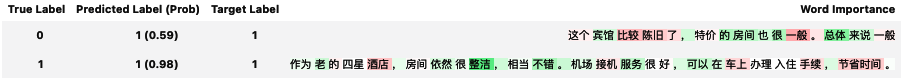

In [18]:
from IPython.display import Image
Image(filename='assets/grad_shap_nlp_viz.png')